In [16]:
import numpy as np

# Load dataset files
synthetic_eeg_eog_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/Linear_synthetic_eeg_eog.npy"
clean_eeg_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/EEG_all_epochs.npy"

# Load the numpy arrays
synthetic_eeg_eog = np.load(synthetic_eeg_eog_path, allow_pickle=True).item()  # Dictionary of SNR levels
clean_eeg = np.load(clean_eeg_path)  # Ground truth EEG

# Inspect dataset keys and shapes
print("🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels):", synthetic_eeg_eog.keys())
print("🔹 Clean EEG Shape:", clean_eeg.shape)

# Print shape of each SNR level data
for snr in synthetic_eeg_eog.keys():
    print(f"🔹 SNR Level {snr}: Shape = {synthetic_eeg_eog[snr].shape}")

# Check statistics of clean EEG data
print("🔹 Clean EEG Mean:", np.mean(clean_eeg))
print("🔹 Clean EEG Std Dev:", np.std(clean_eeg))



🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels): dict_keys([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
🔹 Clean EEG Shape: (3400, 512)
🔹 SNR Level -7: Shape = (3400, 512)
🔹 SNR Level -6: Shape = (3400, 512)
🔹 SNR Level -5: Shape = (3400, 512)
🔹 SNR Level -4: Shape = (3400, 512)
🔹 SNR Level -3: Shape = (3400, 512)
🔹 SNR Level -2: Shape = (3400, 512)
🔹 SNR Level -1: Shape = (3400, 512)
🔹 SNR Level 0: Shape = (3400, 512)
🔹 SNR Level 1: Shape = (3400, 512)
🔹 SNR Level 2: Shape = (3400, 512)
🔹 Clean EEG Mean: -0.16774763156951383
🔹 Clean EEG Std Dev: 231.82429071340553


In [17]:
import torch
from sklearn.model_selection import train_test_split

# Lists to store train/test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# Loop through each SNR level
for snr in synthetic_eeg_eog.keys():
    contaminated_signals = synthetic_eeg_eog[snr]  # Shape: (3400, 512)
    clean_signals = clean_eeg  # Shape: (3400, 512) (Assuming same order for each SNR)

    # Split 80% training, 20% testing
    X_train, X_test, y_train, y_test = train_test_split(
        contaminated_signals, clean_signals, test_size=0.2, random_state=42
    )

    # Append to respective lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Stack training and testing data
X_train_final = np.vstack(X_train_list)
X_test_final = np.vstack(X_test_list)
y_train_final = np.vstack(y_train_list)
y_test_final = np.vstack(y_test_list)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_final, dtype=torch.float32)

# Print final dataset shapes
print("✅ Training Set Shape:", X_train_tensor.shape, "Target Shape:", y_train_tensor.shape)
print("✅ Testing Set Shape:", X_test_tensor.shape, "Target Shape:", y_test_tensor.shape)


✅ Training Set Shape: torch.Size([27200, 512]) Target Shape: torch.Size([27200, 512])
✅ Testing Set Shape: torch.Size([6800, 512]) Target Shape: torch.Size([6800, 512])


In [18]:
import torch.nn as nn

class EEGDnet(nn.Module):
    def __init__(self, seq_len=512, embed_dim=64, num_heads=4, depth=6, mlp_dim=128):
        super(EEGDnet, self).__init__()
        
        # Reshape Layer: Convert 1D EEG (512,) → 2D (8, 64)
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.h, self.w = 8, 64  # Reshaped dimensions

        # Linear Projection to Embed Dim
        self.embedding = nn.Linear(self.w, embed_dim)  # Projects 64 → 64
        self.pos_embedding = nn.Parameter(torch.randn(1, self.h, embed_dim))  # Positional Encoding

        # Transformer Encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=mlp_dim, batch_first=True),
            num_layers=depth
        )

        # Output Layer: Convert back to 1D EEG (512,)
        self.output_layer = nn.Linear(embed_dim, self.w)

    def forward(self, x):
        # Reshape (Batch, 512) → (Batch, 8, 64)
        x = x.view(-1, self.h, self.w)

        # Embedding & Positional Encoding
        x = self.embedding(x) + self.pos_embedding

        # Transformer Encoder
        x = self.transformer(x)

        # Convert back to 1D EEG (Batch, 512)
        x = self.output_layer(x).view(-1, self.seq_len)
        return x

# Initialize Model
model = EEGDnet()
print(model)


EEGDnet(
  (embedding): Linear(in_features=64, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=64, bias=True)
)


In [19]:
import torch.optim as optim

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Move model to GPU
model = EEGDnet().to(device)

# Define loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Early Stopping Parameters
patience = 10  # Stop if validation loss does not improve for 10 epochs
best_val_loss = float('inf')
epochs_no_improve = 0


🔥 Using device: cuda


In [20]:
import time

def train_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=64):
    global best_val_loss, epochs_no_improve
    model.train()
    
    # Move tensors to GPU
    X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # Create Data Loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        start_time = time.time()
        train_loss = 0.0

        # Training loop
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Compute average training loss
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation loss calculation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)  # Move data to GPU
                val_output = model(X_val)
                val_loss += criterion(val_output, y_val).item()
        
        avg_val_loss = val_loss / len(test_loader)
        elapsed_time = time.time() - start_time

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f} - Time: {elapsed_time:.2f}s")

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_eegdnet.pth")  # Save the best model
            print("✅ Model improved! Saving checkpoint.")
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break

        model.train()  # Switch back to training mode

# Start Training with CUDA
train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=5000, batch_size=1024)


Epoch [1/5000] - Train Loss: 53734.972946 - Val Loss: 53641.465960 - Time: 0.79s
✅ Model improved! Saving checkpoint.
Epoch [2/5000] - Train Loss: 53765.991464 - Val Loss: 53621.978237 - Time: 0.69s
✅ Model improved! Saving checkpoint.
Epoch [3/5000] - Train Loss: 53729.143374 - Val Loss: 53597.320871 - Time: 0.82s
✅ Model improved! Saving checkpoint.
Epoch [4/5000] - Train Loss: 53702.903935 - Val Loss: 53570.344866 - Time: 0.76s
✅ Model improved! Saving checkpoint.
Epoch [5/5000] - Train Loss: 53690.552228 - Val Loss: 53542.356027 - Time: 0.76s
✅ Model improved! Saving checkpoint.
Epoch [6/5000] - Train Loss: 53661.827691 - Val Loss: 53514.992188 - Time: 0.79s
✅ Model improved! Saving checkpoint.
Epoch [7/5000] - Train Loss: 53638.412037 - Val Loss: 53489.416295 - Time: 0.76s
✅ Model improved! Saving checkpoint.
Epoch [8/5000] - Train Loss: 53598.203993 - Val Loss: 53466.186942 - Time: 0.61s
✅ Model improved! Saving checkpoint.
Epoch [9/5000] - Train Loss: 53556.828848 - Val Loss: 53

In [9]:
import torch
import numpy as np
from scipy.signal import welch
import torch.nn.functional as F

def compute_rrmse_t(gt, pred):
    """
    Compute Temporal RRMSE (Lower is better).
    Formula: RRMSE_T = ||pred - gt||_2 / ||gt||_2
    """
    return torch.norm(pred - gt, p=2) / torch.norm(gt, p=2)

def compute_rrmse_s(gt, pred, fs=512):
    """
    Compute Spectral RRMSE (Lower is better).
    Formula: RRMSE_S = ||PSD(pred) - PSD(gt)||_2 / ||PSD(gt)||_2
    """
    def compute_psd(signal):
        f, psd = welch(signal, fs=fs, nperseg=256)  # Power Spectral Density
        return torch.tensor(psd, dtype=torch.float32)

    psd_gt = compute_psd(gt.cpu().numpy())
    psd_pred = compute_psd(pred.cpu().numpy())

    return torch.norm(psd_pred - psd_gt, p=2) / torch.norm(psd_gt, p=2)

def compute_cc(gt, pred):
    """
    Compute Correlation Coefficient (Higher is better).
    Formula: CC = Cov(gt, pred) / (std(gt) * std(pred))
    """
    gt_mean, pred_mean = torch.mean(gt), torch.mean(pred)
    numerator = torch.sum((gt - gt_mean) * (pred - pred_mean))
    denominator = torch.sqrt(torch.sum((gt - gt_mean) ** 2) * torch.sum((pred - pred_mean) ** 2))

    return numerator / (denominator + 1e-8)  # Avoid division by zero


In [10]:
def evaluate_per_snr(model, X_test_final, y_test_final):
    """
    Evaluate model performance per SNR level using pre-split test data.
    """
    model.eval()  # Set model to evaluation mode
    
    snr_metrics = {}

    with torch.no_grad():
        # Move test data to GPU
        X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test_final, dtype=torch.float32).to(device)

        # Get model predictions
        y_pred_tensor = model(X_test_tensor)

        # Compute metrics
        rrmse_t = compute_rrmse_t(y_test_tensor, y_pred_tensor).cpu().item()
        rrmse_s = compute_rrmse_s(y_test_tensor, y_pred_tensor).cpu().item()
        cc = compute_cc(y_test_tensor, y_pred_tensor).cpu().item()

        # Store results
        snr_metrics["Overall"] = {
            "RRMSE_T": rrmse_t,
            "RRMSE_S": rrmse_s,
            "CC": cc
        }

        print(f"✅ Overall Test Set Evaluation: RRMSE_T = {rrmse_t:.4f}, RRMSE_S = {rrmse_s:.4f}, CC = {cc:.4f}")

    return snr_metrics


In [11]:
def compute_average_metrics(snr_metrics):
    """
    Compute the final average performance of RRMSE_T, RRMSE_S, and CC across all SNRs.
    """
    avg_rrmse_t = sum([snr_metrics[snr]["RRMSE_T"] for snr in snr_metrics]) / len(snr_metrics)
    avg_rrmse_s = sum([snr_metrics[snr]["RRMSE_S"] for snr in snr_metrics]) / len(snr_metrics)
    avg_cc = sum([snr_metrics[snr]["CC"] for snr in snr_metrics]) / len(snr_metrics)
    
    print("\n🔹 **Final Average Results Across All SNRs** 🔹")
    print(f"✅ Average RRMSE_T: {avg_rrmse_t:.4f} (Lower is better)")
    print(f"✅ Average RRMSE_S: {avg_rrmse_s:.4f} (Lower is better)")
    print(f"✅ Average CC: {avg_cc:.4f} (Higher is better)")

    return avg_rrmse_t, avg_rrmse_s, avg_cc

In [21]:
import torch
import numpy as np
from scipy.stats import pearsonr
from scipy.fftpack import fft

# Function to compute RRMSE
def compute_rrmse(denoised, clean):
    return np.sqrt(np.mean((denoised - clean) ** 2)) / np.sqrt(np.mean(clean ** 2))

# Function to compute RRMSE in the Spectrum Domain
def compute_rrmse_spectrum(denoised, clean):
    fft_clean = np.abs(fft(clean))  # Compute FFT
    fft_denoised = np.abs(fft(denoised))
    return compute_rrmse(fft_denoised, fft_clean)

# Function to compute Correlation Coefficient (CC)
def compute_cc(denoised, clean):
    try:
        return pearsonr(denoised.flatten(), clean.flatten())[0]
    except:
        return 0  # Handle errors gracefully

# Store results
snr_metrics = {}

# Lists to store metrics for computing overall averages
all_rrmse_t = []
all_rrmse_s = []
all_cc = []

# Loop through each SNR level using pre-split test data
with torch.no_grad():
    for snr_idx, snr in enumerate(sorted(synthetic_eeg_eog.keys())):
        print(f"🔹 Evaluating SNR Level: {snr}")

        # Get test data from pre-split dataset
        X_test_snr = X_test_list[snr_idx]  # Noisy EEG from test set
        y_test_snr = y_test_list[snr_idx]  # Clean EEG from test set

        # Convert to PyTorch tensors and reshape for LSTM
        X_test_tensor = torch.tensor(X_test_snr, dtype=torch.float32).unsqueeze(-1).to(device)  # (batch, 512, 1)
        y_test_tensor = torch.tensor(y_test_snr, dtype=torch.float32).unsqueeze(-1).to(device)  # (batch, 512, 1)

        # Get model predictions
        y_pred_tensor = model(X_test_tensor).cpu().detach().numpy()
        y_pred_tensor = y_pred_tensor.reshape(y_test_snr.shape)  # Ensure correct shape

        # Compute metrics
        rrmse_t_list = [compute_rrmse(y_pred_tensor[i], y_test_snr[i]) for i in range(len(y_test_snr))]
        rrmse_s_list = [compute_rrmse_spectrum(y_pred_tensor[i], y_test_snr[i]) for i in range(len(y_test_snr))]
        cc_list = [compute_cc(y_pred_tensor[i], y_test_snr[i]) for i in range(len(y_test_snr))]

        # Store results for this SNR level
        snr_metrics[snr] = {
            "RRMSE-T": np.mean(rrmse_t_list),
            "RRMSE-S": np.mean(rrmse_s_list),
            "CC": np.mean(cc_list)
        }

        # Append values for overall averages
        all_rrmse_t.extend(rrmse_t_list)
        all_rrmse_s.extend(rrmse_s_list)
        all_cc.extend(cc_list)

# Compute Overall Averages
overall_rrmse_t = np.mean(all_rrmse_t)
overall_rrmse_s = np.mean(all_rrmse_s)
overall_cc = np.mean(all_cc)

# Print Results in Table Format
print("\n🔹 **Final Evaluation Per SNR Level:**")
print("-----------------------------------------------------")
print("| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |")
print("-----------------------------------------------------")
for snr in sorted(snr_metrics.keys()):
    print(f"| {snr:3d}  |  {snr_metrics[snr]['RRMSE-T']:.6f}  |  {snr_metrics[snr]['RRMSE-S']:.6f}  |  {snr_metrics[snr]['CC']:.6f}  |")
print("-----------------------------------------------------")

# Print Overall Averages
print("\n🔹 **Overall Averages:**")
print(f"✅ RRMSE-T (Time Domain): {overall_rrmse_t:.6f}")
print(f"✅ RRMSE-S (Spectrum Domain): {overall_rrmse_s:.6f}")
print(f"✅ Correlation Coefficient (CC): {overall_cc:.6f}")


🔹 Evaluating SNR Level: -7
🔹 Evaluating SNR Level: -6
🔹 Evaluating SNR Level: -5
🔹 Evaluating SNR Level: -4
🔹 Evaluating SNR Level: -3
🔹 Evaluating SNR Level: -2
🔹 Evaluating SNR Level: -1
🔹 Evaluating SNR Level: 0
🔹 Evaluating SNR Level: 1
🔹 Evaluating SNR Level: 2

🔹 **Final Evaluation Per SNR Level:**
-----------------------------------------------------
| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |
-----------------------------------------------------
|  -7  |  0.577607  |  0.390658  |  0.813456  |
|  -6  |  0.532585  |  0.367481  |  0.840866  |
|  -5  |  0.494733  |  0.347476  |  0.862687  |
|  -4  |  0.463439  |  0.329744  |  0.879655  |
|  -3  |  0.437509  |  0.314572  |  0.892813  |
|  -2  |  0.416512  |  0.302055  |  0.902831  |
|  -1  |  0.398998  |  0.291238  |  0.910786  |
|   0  |  0.383609  |  0.281916  |  0.917608  |
|   1  |  0.370307  |  0.274039  |  0.923359  |
|   2  |  0.358411  |  0.267252  |  0.928386  |
-----------------------------------------------------

🔹 **Overa

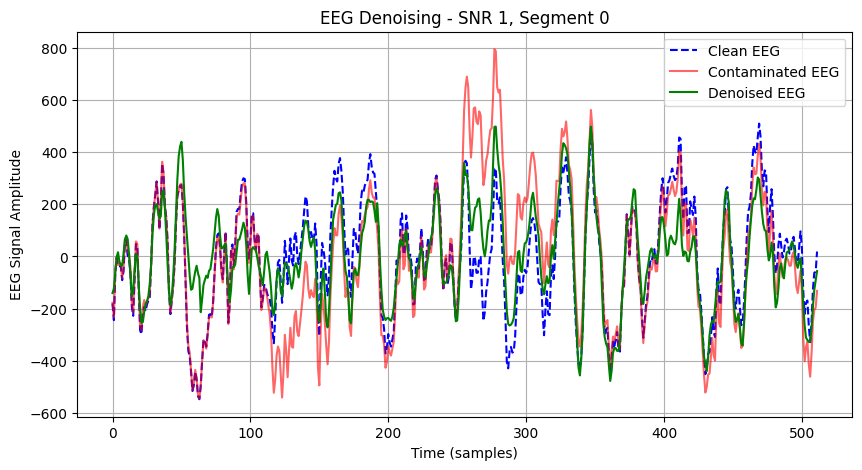

In [22]:
import matplotlib.pyplot as plt

# Select SNR=1 and 0th segment
snr_level = 1
snr_idx = list(sorted(synthetic_eeg_eog.keys())).index(snr_level)  # Find the index of SNR=1

# Get test data
noisy_snr = X_test_list[snr_idx]  # Noisy (contaminated) EEG from test set
clean_snr = y_test_list[snr_idx]  # Clean EEG from test set

# Convert to PyTorch tensor and denoise
noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).unsqueeze(-1).to(device)  # (batch, 512, 1)
denoised_tensor = model(noisy_tensor).cpu().detach().numpy()
denoised_tensor = denoised_tensor.reshape(clean_snr.shape)  # Ensure correct shape

# Select the 0th segment (first sample)
segment_idx = 0
noisy_segment = noisy_snr[segment_idx]
clean_segment = clean_snr[segment_idx]
denoised_segment = denoised_tensor[segment_idx]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
plt.plot(denoised_segment, label="Denoised EEG", color="green", linewidth=1.5)

plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal Amplitude")
plt.title(f"EEG Denoising - SNR {snr_level}, Segment {segment_idx}")
plt.legend()
plt.grid(True)
plt.show()
